In [67]:
print('Link Hysteresis Energy optimization')

Link Hysteresis Energy optimization


In [68]:
import os
import sys
import comtypes.client
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pygad

#import cProfile

In [97]:
SapObject = comtypes.client.GetActiveObject("CSI.SAP2000.API.SapObject")
SapModel = SapObject.SapModel
SapModel.SetModelIsLocked(False)

0

In [98]:
def link_option(Y_strength, L_name):
    """
    Modifies the yield strength for M3 of the selected link element
    Arguments:
        Y_strength: new yield strength
        L_name: Link name
    """
    DOF = [False, False, False, False, False, False]
    Fixed = [False, False, False, False, False, False]
    NonLinear = [False, False, False, False, False, False]
    Ke = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    Ce = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    K =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    Yield = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    Ratio = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    Exp =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

    DOF[0] = True
    Fixed[0] = True

    DOF[1] = True
    Fixed[1] = True

    DOF[2] = True
    Fixed[2] = True

    DOF[3] = True
    Fixed[3] = True

    DOF[3] = True
    Fixed[3] = True

    DOF[4] = True
    Fixed[4] = True

    DOF[5] = True
    NonLinear[5] = True
    Ke[5] = 100000
    Ce[5] = 0
    K[5] = 100000
    Yield[5] = Y_strength
    Ratio[5] = 0.03
    Exp[5] = 2
    ret = SapModel.PropLink.SetPlasticWen(L_name, DOF, Fixed, NonLinear, Ke, Ce, K, Yield, Ratio, Exp, 2, 0)
    ret = SapModel.PropLink.SetPDelta(L_name, [0.5, 0.5, 0.5, 0.5])

In [99]:
def cycle_number(result):
    """
    Calculates the number of load-unload cycles
    Arguments :
        result : pandas DataFrame with Force-Displacment results
    Returns :
        c : number of cycles
        result : modifies results DataFrame
    """
    result['q2'] = 0
    result['c'] = 0
    q1 = 0
    q2 = 0
    c = 0
    for i in range(len(result)-1):
        if result['Force'][i] >= 0.0 and result['Desplacment'][i] >= 0.0 : 
            q2 = 1
            result['q2'][i] = q2
        if result['Force'][i] < 0.0 and result['Desplacment'][i] > 0.0 : 
            q2 = 2
            result['q2'][i] = q2
        if result['Force'][i] < 0.0 and result['Desplacment'][i] < 0.0 : 
            q2 = 3
            result['q2'][i] = q2
        if result['Force'][i] > 0.0 and result['Desplacment'][i] < 0.0 : 
            q2 = 4
            result['q2'][i] = q2
        
        
        if q1 > q2 and q2 ==1:
            c += 1
        result['c'][i] = c

        q1 = q2
    return c, result


In [100]:
def Area(result):
    """
    Calculates the area under the function curve for a set of points using Trapezoidal rule
    Arguments : 
        result : DataFrame with the function data points
    Returns : 
        Energy : The area under the function curve
    """
    #Energy = np.abs(result['Desplacment'][len(result)-1]*result['Force'][0] - result['Desplacment'][0]*result['Force'][len(result)-1])/2
    Energy = 0
    for i in range(len(result)-1):
        Area = result['Desplacment'][i]*result['Force'][i+1] - result['Desplacment'][i+1]*result['Force'][i]
        #Area = (result['Force'][i] + result['Force'][i+1]) / 2 * (result['Desplacment'][i+1]- result['Desplacment'][i])
        Energy = Energy +  np.abs(Area)
    return Energy

In [101]:

def energy_func(result):
    """
    Calculates the hysteresis energy for a selected hysteresis plot
    Arguments :
        result : pandas DataFrame with Force-Displacment results
    Returns :
        E : Energy
        c : number of loops
    """
    
    c, result = cycle_number(result)
    E = []
    for i in range(1,c+1):
        df = result[result['c']== i ].reset_index()
        A = Area(df)
        E.append(A)
    E = np.max(np.array(E))
    return E, c


In [102]:

def get_data(L_num, save_path,Plot_graph = True):
    """
    Gets the analysis results
    Arguments:
        L_num: Link number
        save_path: Path to save hysteresis plots of the selected link
        Plot_graph : If true saves the hysteresis plots and results of the selected link
    Returns:
        result : Pandas DataFrame with the analysis results
        Energy : Hysteresis energy of the selected link
        c : number of hysteresis loops
    """
    eItemTypeElm = 1
    NumberResults = 0
    Obj =[]
    Elm =[]
    PointElm =[]
    LoadCase =[]
    StepType =[]
    StepNum =[]
    P =[]
    V2 =[]
    V3 =[]
    T =[]
    M2 =[]
    M3 =[]

    U1=[]
    U2=[]
    U3=[]
    R1=[]
    R2=[]
    R3=[]
    SapModel.Results.Setup.SetOptionModalHist(2)
    SapModel.Results.Setup.SetOptionDirectHist(2)
    [NumberResults, Obj, Elm, LoadCase,PointElm, StepType, StepNum, P, V2, V3, T, M2, M3, ret] = SapModel.Results.LinkForce(L_num, eItemTypeElm, NumberResults, Obj, Elm, PointElm, LoadCase, StepType, StepNum, P, V2, V3, T, M2, M3)
    [NumberResults, Obj, Elm, LoadCase, StepType, StepNum, U1, U2, U3, R1, R2, R3, ret]= SapModel.Results.LinkDeformation(L_num, eItemTypeElm, NumberResults, Obj, Elm, LoadCase, StepType, StepNum, U1, U2, U3, R1, R2, R3)
    result = pd.DataFrame()

    result['Desplacment'] = R3
    result['Force'] = M3[0:len(M3):2]

    if Plot_graph:
        plt.plot(result['Desplacment'], result['Force'])
        plt.grid()
        save_path_csv = save_path + '/'+ str(L_num) + ".csv"
        save_path = save_path + '/'+ str(L_num) + ".png"
        result.to_csv(save_path_csv, index = False)
        plt.savefig(save_path)
        plt.close()

    Energy, c = energy_func(result)


    return result, Energy, c

In [103]:
def drift_check(story_ids, Story_height, drift_limit):
    """ 
    Checks the inter story drift limitation 
    Arguments : 
        story_ids : Joints ids from each story
        Story_height : story height in meters
        drift_limit : drift limitation in %
    Returns : 
        Check : Boolean, True if the limitation is exceeded
    """
    Check = False
    U = []
    for joint in story_ids :
        eItemTypeElm = 1
        NumberResults = 0
        Obj =[]
        Elm =[]
        PointElm =[]
        LoadCase =[]
        StepType =[]
        StepNum =[]


        U1=[]
        U2=[]
        U3=[]
        R1=[]
        R2=[]
        R3=[]
        SapModel.Results.Setup.SetOptionModalHist(1)
        SapModel.Results.Setup.SetOptionDirectHist(1)
        [NumberResults, Obj, Elm, LoadCase, StepType, StepNum, U1, U2, U3, R1, R2, R3, ret]= SapModel.Results.JointDispl(joint, eItemTypeElm, NumberResults, Obj, Elm, LoadCase, StepType, StepNum, U1, U2, U3, R1, R2, R3)
        U.append(np.abs(U1[0]))
    U = np.array(U)
    drift = []
    drift.append(np.abs(U[0])/Story_height*100)
    for i in range(1,len(U)):
        inter_story_drift = np.abs(U[i]-U[i-1])/Story_height*100
        drift.append(inter_story_drift)
    if np.max(drift) > drift_limit : 
        Check = True
    return Check

In [94]:
def main(Y_strength, Link_names, Link_labels, Load_case_name, Cycle_limit, joints, Story_height, drift_limit, save_data = False):
    """
    Calculates the total hysteresis energy of the structure for a selected yield strength values
    Aeguments : 
        Y_strength : List of Yield strengths for each link
        Link_names : Link section names
        Link_labels : Links labels
        Load_case_name : Non-linear load case name
        Cycle_limit : Limit for load-unload cycles
        joints : Joints ids from each story
        Story_height : story height in meters
        drift_limit : drift limitation in %
        save_data : If True, saves the hysteresis plots for each link element in /plots
    Returns :
        Total hysteresis energy of the structure
    """
    print(Y_strength)
    SapModel.SetModelIsLocked(False)
    Link_list = Link_names
    Link_numbers = Link_labels
    for link_name in Link_list:
        link_option( Y_strength[Link_list.index(link_name)], link_name)
    
    SapModel.Analyze.RunAnalysis()
    SapModel.Results.Setup.DeselectAllCasesAndCombosForOutput()
    SapModel.Results.Setup.SetCaseSelectedForOutput(Load_case_name)
    SapModel.Results.Setup.SetOptionModalHist(2)
    SapModel.Results.Setup.SetOptionDirectHist(2)


    E = []
    plot_dirc = os.path.join("plots/", str(Y_strength)) 
    os.makedirs(plot_dirc, exist_ok=True) 
    for num in Link_numbers:
        r, e, c = get_data(num, plot_dirc, Plot_graph= save_data)
        if c > Cycle_limit: 
            E_tot = 0
            break
        E.append(e)
    E_tot = np.sum(E)    

    if drift_check(joints, Story_height, drift_limit):
        E_tot = 0        
    print('E = ',E_tot)
    return E_tot


In [95]:

# The benchmark

# initial solution

Y_strength = [550, 550, 550, 550, 550]

Cycle_limit = 60 # Limit on hysteresis loops number

Link_names = ['LINK1', 'LINK2','LINK3','LINK4','LINK5'] # Links names

num_links = 20 # Number of links
Link_labels = range(1, num_links+1)
Link_labels = [format(x, 'd') for x in Link_labels] # generates list with Link numbers

Story_height = 3.0 # story heigh in meters
drift_limit = 5 # interstory drift in %
joints = ["2", "13", "27", "38", "49"] # joints number for story

Load_case_name = "ARTIF1" # Nonlinear load case name


In [96]:
benchmark = main(Y_strength, Link_names, Link_labels, Load_case_name, Cycle_limit, joints, Story_height, drift_limit)

[200, 200, 200, 200, 200]
E =  64.63287376796652


In [22]:
#cProfile.run('main(Y_strength, Link_names, Link_labels, Load_case_name, Cycle_limit)')

In [65]:
def fitness_func(solution, solution_idx):
    """
    Only allows to solutions better than our initial model (benchmark) to continue to the next generation
    """
    fitness_score = main(solution, Link_names, Link_labels, Load_case_name, Cycle_limit, joints, Story_height, drift_limit)
    if fitness_score < benchmark :
        fitness_score = 0.0
    print('fitness score = ',fitness_score)
    return fitness_score

last_fitness = 0

def on_generation(ga_instance):
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness))
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]

fitness_function = fitness_func

num_generations = 5 #iteratinos
num_parents_mating = 2 

sol_per_pop = 5 # solutions per iteration
num_genes = len(Y_strength) 

init_range_low = 80 # lowest solution limit
init_range_high = 300 # highest solution limit

parent_selection_type = "sss" # rank_selection()"sss"
keep_parents = -1 # keep all parents

initial_population=[[240, 240, 240, 240, 240],
                    [550, 550, 550, 550, 550],
                    [235, 235, 235, 235, 235],
                    [862, 862, 862, 862, 862],
                    [300, 300, 300, 300, 300]
                    ]

crossover_type = "two_points" #"uniform" #"single_point"

mutation_type =  "random" #"swap"
mutation_percent_genes = 60

ga_instance = pygad.GA(#on_generation=on_generation,
gene_type=int,
initial_population = initial_population,
                        num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes
                       )


In [66]:
# %%
ga_instance.run()

# %%


[240 240 240 240 240]
E =  62.38634699282875
fitness score =  62.38634699282875
[550 550 550 550 550]
E =  30.068834268492516
fitness score =  30.068834268492516
[235 235 235 235 235]
E =  62.86288505808702
fitness score =  62.86288505808702
[862 862 862 862 862]
E =  14.833638858744678
fitness score =  0.0
[300 300 300 300 300]
E =  53.54286600472873
fitness score =  53.54286600472873
[240 240 234 235 235]
E =  62.815142922853
fitness score =  62.815142922853
[240 240 240 235 234]
E =  62.64367476048511
fitness score =  62.64367476048511
[240 239 235 235 235]
E =  62.78587032692316
fitness score =  62.78587032692316
[239 235 235 239 239]
E =  62.61367713299159
fitness score =  62.61367713299159
[235 240 234 235 234]
E =  62.905179606837414
fitness score =  62.905179606837414
[235 235 234 235 235]
E =  62.88991461744702
fitness score =  62.88991461744702
[239 240 235 235 235]
E =  62.80733275938981
fitness score =  62.80733275938981
[235 235 233 234 235]
E =  62.969811900128114
fitness

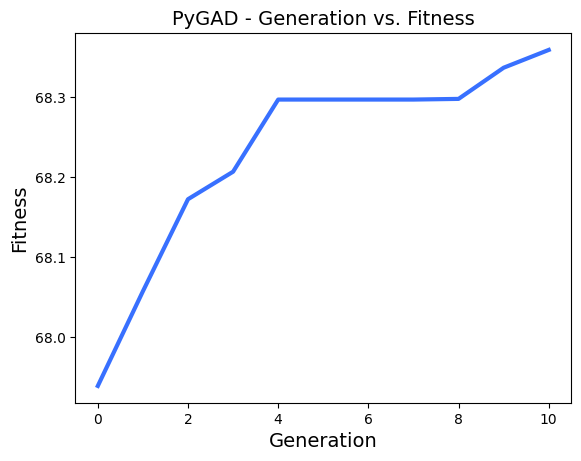

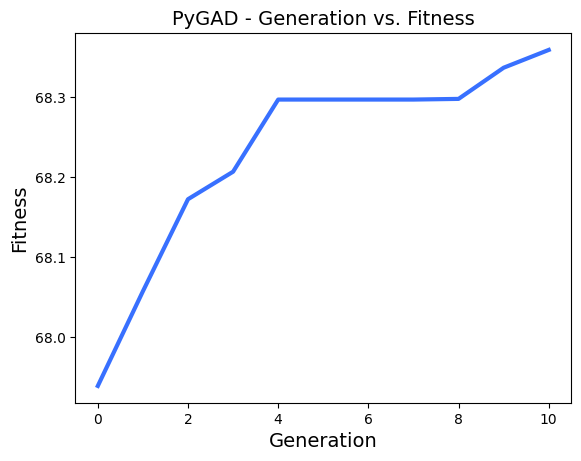

In [33]:
ga_instance.plot_fitness()

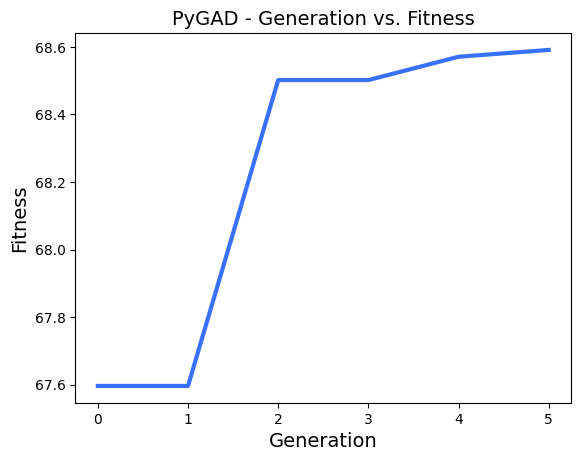

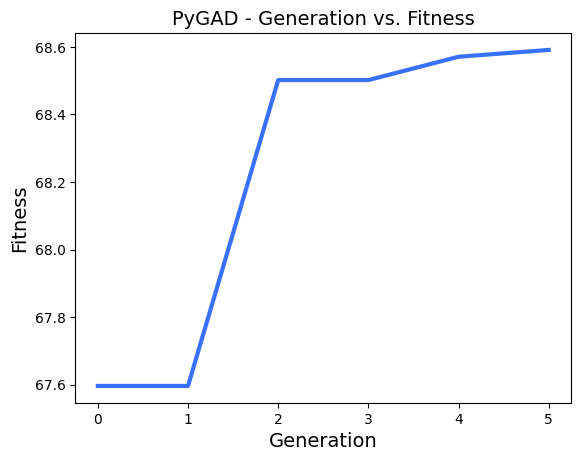

In [30]:
ga_instance.plot_fitness()

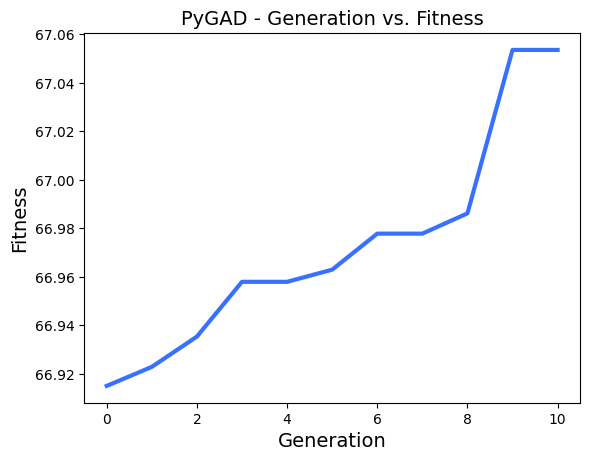

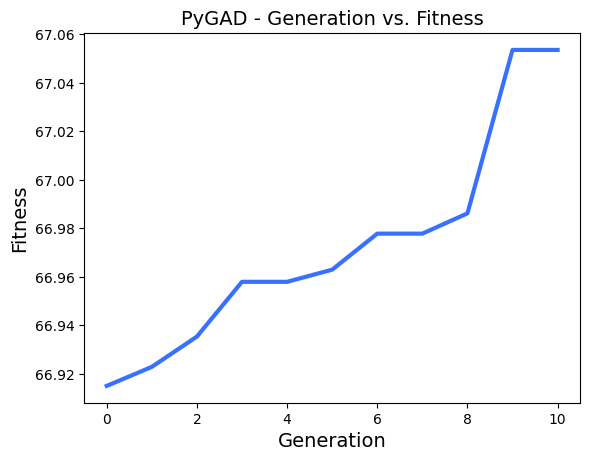

In [20]:
ga_instance.plot_fitness()

In [ ]:
# %% Solution
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
